# Model-based Reinforcement Learning

In the context of dynamic programming, algorithms **requires a model** of the environment and they calculate optimal policies offline, on the other hand, in the reinforcement learning context we presented several **model-free** learning methods. The advantage of model-free methods is that they doesn’t require information about the MDP internals. Often the MDP is challenging to obtain in advance or it is even impossible to obtain: imagine to represents the game of Go with its 10.170 possible states or the StarCraft II game with 101.685 states. Not requiring the MDP in advance is a of crucial importance. However, what if we don’t require the MDP in advance, but perhaps **learn one as we interact** with the environment? 

We can imagine agents that interact with the environment (like the model-free methods) and also learn a model of the environment from these interactions and use the model to improve their behavior (line dynamic programming), we call this second phase **plannig** since it is not base on interaction. By exploiting the learned model, agents often require fewer experience samples to learn optimal policies. These methods are called **model-based reinforcement learning**.

We use again the **Slippery Walk** environment. Remember, this environment is a walk, a single-row slippery (stochastic) grid-world environment, with seven non-terminal states. If the agent chooses to go left, there is a chance it does, but there is also a chance that it goes right, or that it stays in place

In [137]:
import random
import numpy as np
        
class SlipperyWalk:
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = 9
        self.action_space = 2
        self._state = np.random.choice([1,2,3,4,5,6,7])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')
        
        if(action==0): direction = -1
        if(action==1): direction = 1
        
        direction_list = [direction, -direction, 0]
        true_direction = random.choices(direction_list, weights=(50, 17, 33), k=1)
        self._state += true_direction[0]
        
        reward = 0
        if self._state < 1: self._done = True
        if self._state > 7: self._done = True; reward = 1
        return self._state, reward, self._done, 0  # obs, rew, done

In [138]:
slippery_walk = SlipperyWalk()

## Learning sample models: Dyna-Q

Dyna-Q ([Richard S. Sutton, "Dyna, an integrated architecture for learning, planning, and reacting", ACM SIGART Bulletin, 1991](https://dl.acm.org/doi/10.1145/122344.122377)) consists of interleaving a model-free RL method (like Q-learning) and a model-based method (like value iteration) and using both experiences sampled from the environment and experiences sampled from the learned model to improve the action-value function.

We keep track of the transition and reward functions as three-dimensional tensors indexed by state, action, and next state. The transition tensor keeps count of the number of times we’ve seen the tuple (s, a, s') indicating how many times we arrived at state s' from state s when selecting action a. The reward tensor holds the average reward we received on the tuple (s, a, s') indicating the expected reward when we select action a on state s and transition to state s'.

<img src="./images/model-based-rl.png" width="800">

In order to decay alpha and epsilon, we use the same decay schedule function already used several times:

In [139]:
def decay_schedule(init_value, min_value, decay_steps, max_steps):
    rem_steps = max_steps - decay_steps
    values = np.logspace(start=0, stop=-2, num=decay_steps, base=10)
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

And again we use a decaying epsilon-greedy approach to control the exploration:

In [140]:
def select_action(state, Q, epsilon):
    if np.random.uniform() > epsilon:
        action = np.argmax(Q[state])
    else:
        action = np.random.randint(len(Q[0]))

    return action;

In [146]:
def dyna_q(env, gamma=1.0,init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=2000,
           n_planning=3, n_episodes=3000):
    
    nS, nA = env.observation_space, env.action_space
    pi_track =[]
   
    Q = np.zeros((nS, nA), dtype=float)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    # create a function to keep track of the transition function.
    # and another one to keep track of the reward signal.
    T_count = np.zeros((nS, nA, nS), dtype=int)
    R_model = np.zeros((nS, nA, nS), dtype=float)
    T_track, R_track, planning_track = [], [], []
    
    # calculate all alphas at once
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    # the episode loop
    for e in range(n_episodes):
                   
        state, done = env.reset(), False
        
        while not done:
                   
            # select the action, as in Q-learning       
            action = select_action(state, Q, epsilons[e])
                   
            # step the environment and get the experience tuple
            next_state, reward, done, _ = env.step(action)

            # start learning the model! 
            # increment the transition count for the state-action-next_state triplet 
            T_count[state][action][next_state] += 1
            
            # calculate an incremental mean of the reward signal
            # and use it to learn the reward signal
            r_diff = reward - R_model[state][action][next_state]
            R_model[state][action][next_state] += (r_diff / T_count[state][action][next_state])

            # calculate the TD target as usual, Q-learning style 
            # (off-policy, using the max)
            td_target = reward + gamma * Q[next_state].max()
            
            # and the TD error
            td_error = td_target - Q[state][action]
            
            # finally, update the Q-function
            Q[state][action] = Q[state][action] + alphas[e] * td_error

            # get into the planning steps, first back up the next state variable.       
            backup_next_state = next_state
            
            # planning loop
            for _ in range(n_planning):
                   
                # make sure there have been updates to the Q-function before, 
                # otherwise, there’s not much to plan
                if Q.sum() == 0: 
                    break

                # select a state from a list of states already visited by 
                # the agent in experience   
                visited_states = np.where(np.sum(T_count, axis=(1, 2)) > 0)[0]
                state = np.random.choice(visited_states)

                # then select an action that has been taken on that state   
                actions_taken = np.where(np.sum(T_count[state], axis=1) > 0)[0]
                action = np.random.choice(actions_taken)

                # use the count matrix to calculate probabilities of a next state 
                # and then a next state   
                probs = T_count[state][action]/T_count[state][action].sum()
                next_state = np.random.choice(np.arange(nS), size=1, p=probs)[0]
                
                # use the reward model as the reward
                reward = R_model[state][action][next_state]
                planning_track.append((state, action, reward, next_state))

                # update the Q-function using that simulated experience!    
                td_target = reward + gamma * Q[next_state].max()
                td_error = td_target - Q[state][action]
                Q[state][action] = Q[state][action] + alphas[e] * td_error
            
            V = np.max(Q, axis=1)
            
            # at the end of the planning steps, set the state as the next state
            state = backup_next_state

        T_track.append(T_count.copy())
        R_track.append(R_model.copy())
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]

    return Q, V, pi, Q_track, V_track, pi_track, T_track, R_track, np.array(planning_track)

We can apply DynaQ to the Slippery Walk environment and try to understand the  model learned by the algorithm.

In [147]:
Q_dyna, V_dyna, pi_dyna, Q_track_dq, V_track_dq, pi_track_dq, T_track_dq, R_track_dq, planning_dq = dyna_q(slippery_walk)

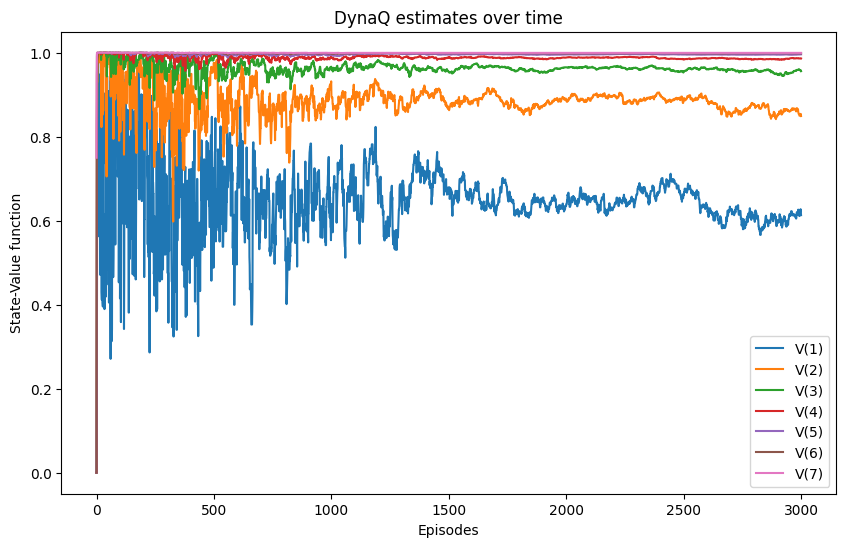

In [145]:
import matplotlib.pyplot as plt

legends = ['V(1)','V(2)','V(3)','V(4)','V(5)', 'V(6)', 'V(7)']

plt.figure(figsize=(10,6))
plt.plot(V_track_dq[:,1:8])
plt.title('DynaQ estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)

plt.show()

We can plot a 3D graph of the learned transition model at different episodes in order to see how the algorithm learns the model of the environment. The axis to the right is the initial state, the axis to the left is the landing state, the colors are the actions, and bar heights are the transition probabilities.

In [104]:
def plot_transition_model(T_track, episode = 0):
    
    np.seterr(divide='ignore', invalid='ignore')

    fig = plt.figure(figsize=(20,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=20, azim=50)

    plt.title('Learned MDP after {} episodes'.format(episode+1))
    ax.set_xlabel('Initial state')
    ax.set_ylabel('Landing state')
    ax.set_zlabel('Transition probabilities')

    left_prob = np.divide(T_track[episode][:,0].T, T_track[episode][:,0].sum(axis=1).T).T
    right_prob = np.divide(T_track[episode][:,1].T, T_track[episode][:,1].sum(axis=1).T).T

    for s in np.arange(9):
        ax.bar3d(s+0.1, np.arange(9)+0.1, np.zeros(9), np.zeros(9)+0.3, np.zeros(9)+0.3, left_prob[s], color='yellow')
        ax.bar3d(s+0.1, np.arange(9)+0.1, left_prob[s], np.zeros(9)+0.3, np.zeros(9)+0.3, right_prob[s], color='red')
  
    left_proxy = plt.Rectangle((0, 0), 1, 1, fc='yellow')
    right_proxy = plt.Rectangle((0, 0), 1, 1, fc='red')
    plt.legend((left_proxy, right_proxy), ('Left', 'Right'))

    plt.show()

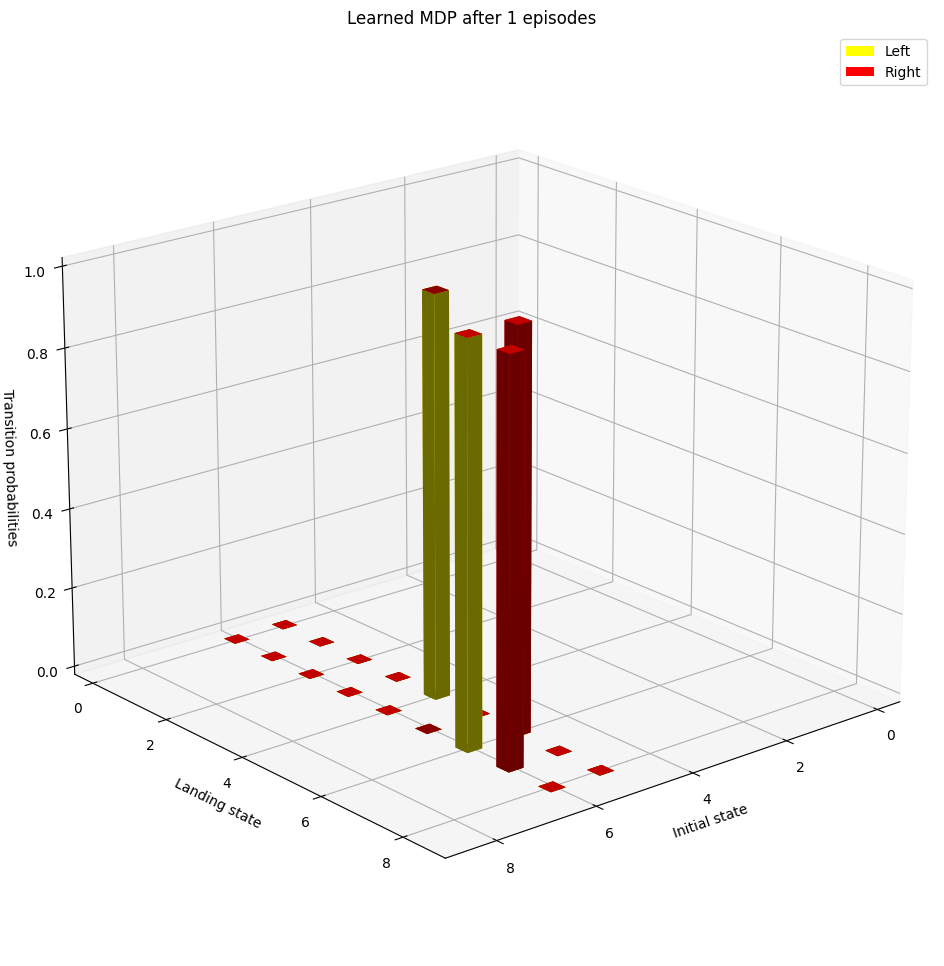

In [105]:
plot_transition_model(T_track_dq, episode=0)

This is the model that Dyna-Q has learned after one episode. There are obvious issues with this model, but also, this is only after a single episode. This could mean trouble when using the learned model early on because there will be a bias when sampling an incorrect model.

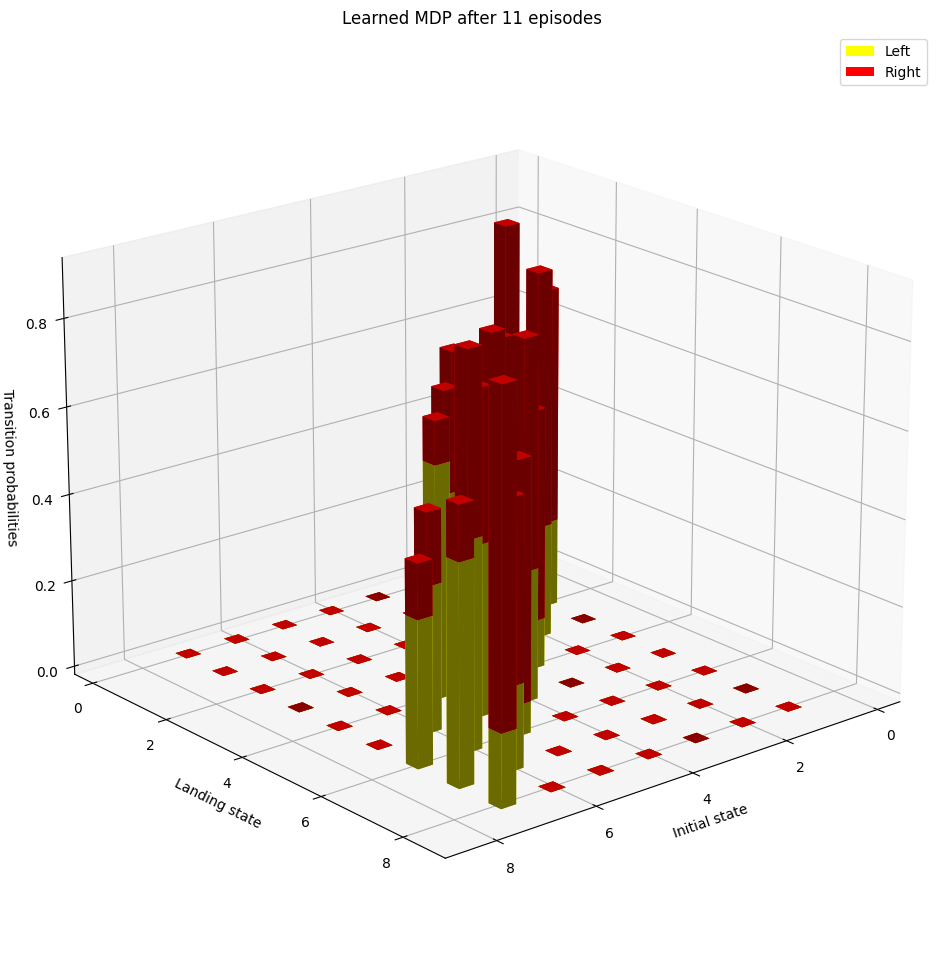

In [106]:
plot_transition_model(T_track_dq, episode=10)

Only after 10 episodes, we can see the model taking shape. We can see the right probabilities coming together. 

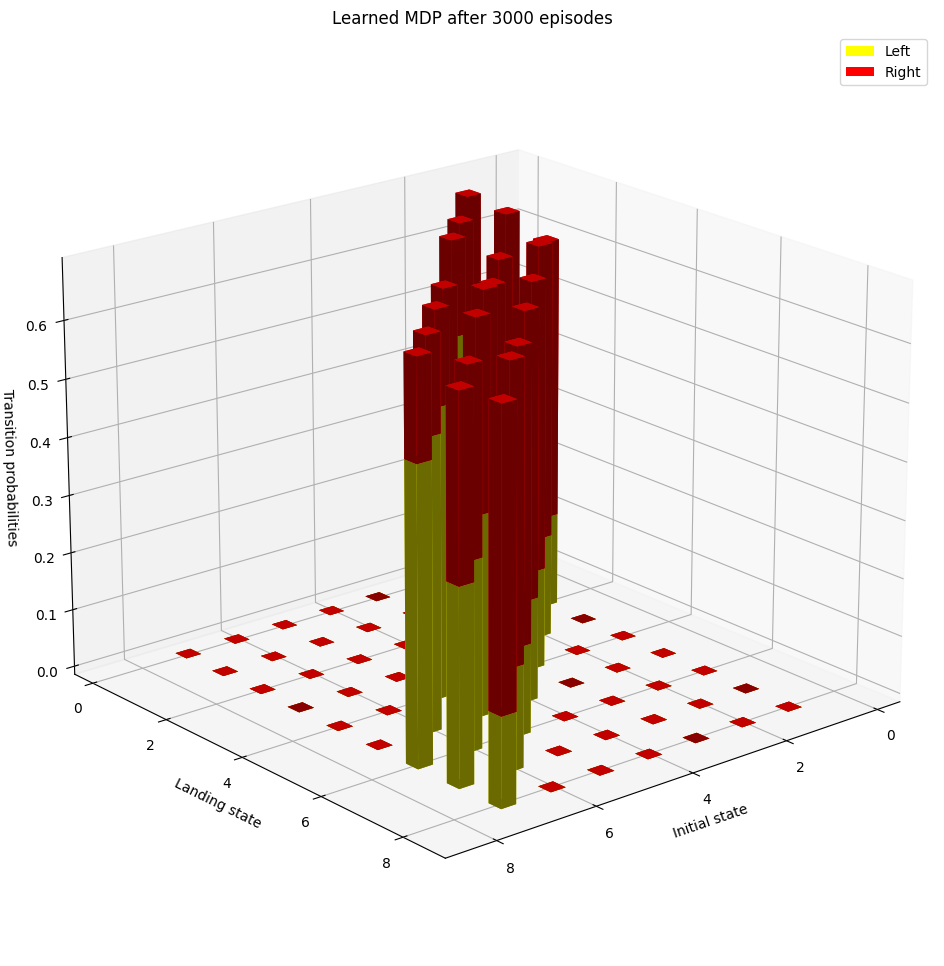

In [107]:
plot_transition_model(T_track_dq, episode=len(T_track_dq)-1)

At the end, the probabilities are good enough and describe the MDP correctly. Obviously, this is a simple environment, so the agent can gather enough experience samples for building an MDP quickly.

## Making plans for the immediate future: Trajectory sampling

During the planning in DynaQ, we sample a state uniformly from the state-action pairs that have been visited (so we don’t waste time with state-action pairs about which the model has no information) and then we sample uniformly an action from previously selected actions. This point can be more effective if we used **a state that we expect to encounter during the current episode** and if **sample actions from the same behavioral policy (on policy) or from a greedy policy with respect to the current estimates (off policy)** at the given time step. This is what **Trajectory sampling** does ([A.G. Barto, S.J. Bradtke, S.P. Singh, "Learning to act using real-time dynamic programming", Artificial intelligence, 1995](https://www.sciencedirect.com/science/article/pii/000437029400011O/pdf?md5=9fb6f16e901b8dfff10140c0009a84a1&pid=1-s2.0-000437029400011O-main.pdf)). We can implement it in Python, for the most part, the code is the same as Dyna-Q, with a few exceptions:

In [132]:
def trajectory_sampling(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=2000,
                        n_planning=3, n_episodes=2000):
            
    nS, nA = env.observation_space, env.action_space
    pi_track =[]
   
    Q = np.zeros((nS, nA), dtype=float)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    T_count = np.zeros((nS, nA, nS), dtype=int)
    R_model = np.zeros((nS, nA, nS), dtype=float)
    T_track, R_track, planning_track = [], [], []
    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)

    for e in range(n_episodes):
                   
        state, done = env.reset(), False

        while not done:
            action = select_action(state, Q, epsilons[e])
            next_state, reward, done, _ = env.step(action)
            
            T_count[state][action][next_state] += 1
            r_diff = reward - R_model[state][action][next_state]
            R_model[state][action][next_state] += (r_diff / T_count[state][action][next_state])

            td_target = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[e] * td_error
            
            backup_next_state = next_state

            for _ in range(n_planning):
                
                if Q.sum() == 0: 
                    break

                # select the action following the behavioral policy or from the greedy policy ì
                # select_action(state, Q, epsilons[e])
                action = Q[state].argmax()
                    
                # if we haven’t experienced the transition, 
                # planning would be a mess, so break out
                if not T_count[state][action].sum(): 
                    break

                # otherwise, get the probabilities of next_state and sample 
                # the model accordingly, as in DynaQ
                probs = T_count[state][action]/T_count[state][action].sum()
                next_state = np.random.choice(np.arange(nS), size=1, p=probs)[0]
                    
                # get the reward as prescribed by the reward-signal model, as in DynaQ
                reward = R_model[state][action][next_state]
                planning_track.append((state, action, reward, next_state))

                    
                # continue updating the Q-function as if with real experience, as in DynaQ
                td_target = reward + gamma * Q[next_state].max()
                td_error = td_target - Q[state][action]
                Q[state][action] = Q[state][action] + alphas[e] * td_error

                # we update the state variable before we loop and 
                # continue the planning steps
                state = next_state

            V = np.max(Q, axis=1)
            
            # outside the planning loop, we restore the state, 
            # and continue real interaction steps
            state = backup_next_state

        T_track.append(T_count.copy())
        R_track.append(R_model.copy())
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track, T_track, R_track, np.array(planning_track)

Apply to the Slippery Walk environment:

In [128]:
Q_ts, V_ts, pi_ts, Q_track_ts, V_track_ts, pi_track_ts, T_track_ts, R_track_ts, planning_ts = trajectory_sampling(slippery_walk)

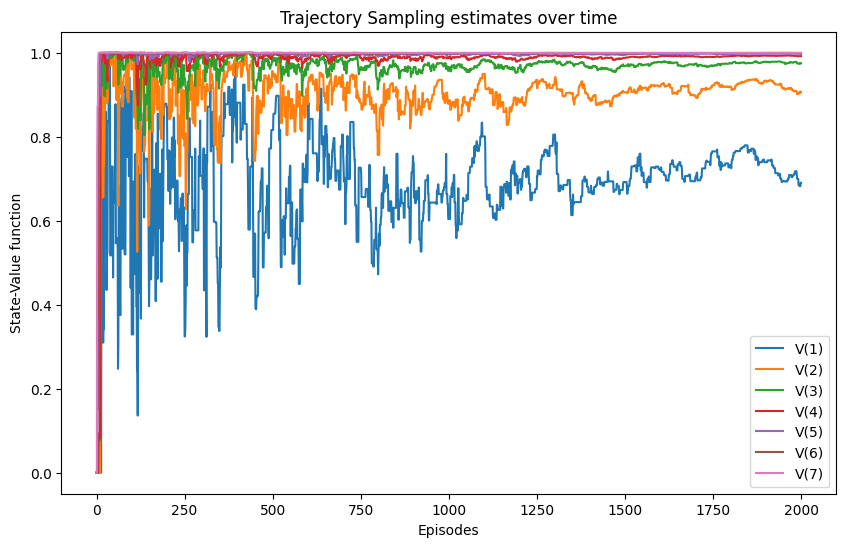

In [133]:
import matplotlib.pyplot as plt

legends = ['V(1)','V(2)','V(3)','V(4)','V(5)', 'V(6)', 'V(7)']

plt.figure(figsize=(10,6))
plt.plot(V_track_ts[:,1:8])
plt.title('Trajectory Sampling estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)

plt.show()

We can compare the difference in sampling the model from DynaQ and Trajectory sampling. We can plot the states that were sampled by the planning phase of the two algorithms and the actions selected in those states. 

In [134]:
def plot_model_state_sampling(planning, algo):
    plt.figure(figsize=(10,6))

    plt.title('States samples from {}'.format(algo))
    plt.xlabel('Initial states sampled',)
    plt.ylabel('Count')
    plt.legend(['Left', 'Right'])
    
    for s in np.arange(9):
        actions = planning[np.where(planning[:,0]==s)[0], 1]
        left = len(actions[actions == 0])
        right = len(actions[actions == 1])
        plt.bar(s, right, 0.2, color='yellow')
        plt.bar(s, left, 0.2, color='red', bottom=right)
    
    plt.show()

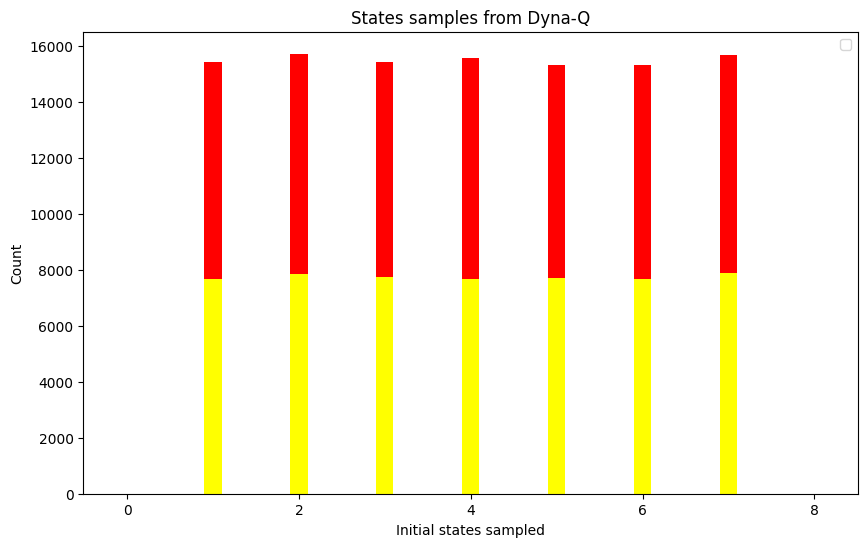

In [135]:
plot_model_state_sampling(planning_dq, algo='Dyna-Q')

Notice that Dyna-Q samples uniformly at random, not only the states, but also the actions taken in those states.

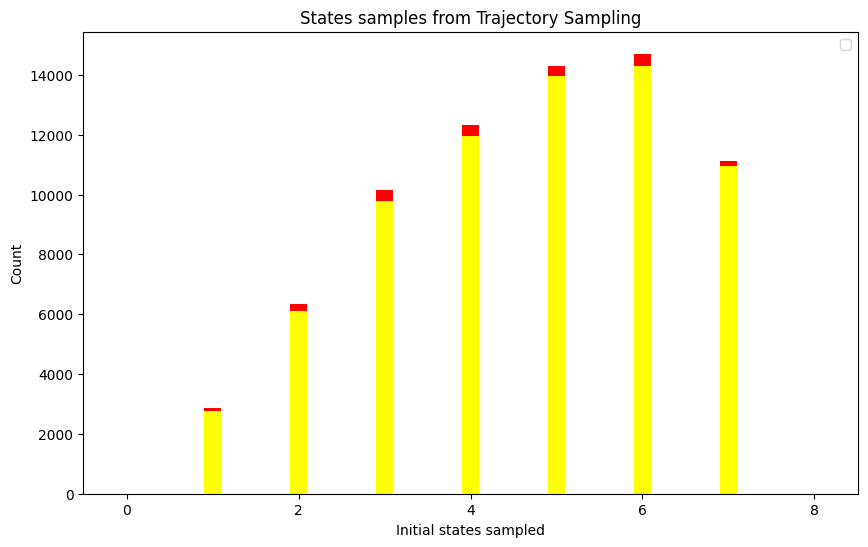

In [136]:
plot_model_state_sampling(planning_ts, algo='Trajectory Sampling')

With trajectory sampling, we have a different sampling strategy. The rightmost state is the only non-zero reward state. The greedy trajectory sampling strategy samples the model in an attempt to improve greedy action selection. This is the reason why the states sampled are skewed toward the goal state. The same happens with the sampling of the action. As we can see, the right action is sampled far more than the left action across the board. In that way, Trajectory sampling **lands on the goal state far more often, therefore experiencing non-zero rewards from the model more frequently**.